## Round 2 of model fitting and selection
## Pick the features highlighted in round1
## Check a few strategies

In [1]:
 !pip install fastparquet

In [2]:
!pip install -U imbalanced-learn

In [3]:
import imblearn
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN, BorderlineSMOTE, SVMSMOTE, KMeansSMOTE

In [4]:
import pandas as pd
import numpy as np
import os as os
import datetime   

import sklearn
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import sklearn.model_selection
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn import metrics

from sklearn.datasets import make_classification
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, average_precision_score

pd.set_option('display.max_rows', 500)

import seaborn as sns
import matplotlib as plt

datadir = '/challenge/seeing-through-the-fog/data/train_data'

In [5]:
## Read in df_tar
df_tar = pd.read_parquet(datadir + "/" + "target.parquet")


## Read in inner and outer merge training data master tables
master_inner_join = '/home/huangz36/test_process/master_table_inner_merge.txt'
master_outer_join = '/home/huangz36/test_process/master_table_outer_merge.txt'

df_inner = pd.read_csv(master_inner_join, sep='\t', header=0)
df_outer = pd.read_csv(master_outer_join, sep='\t', header=0)

df_inner_tar = df_tar.merge(df_inner, how='inner', on='patientid')
df_outer_tar = df_tar.merge(df_outer, how='inner', on='patientid')

print("inner shape", df_inner_tar.shape)
print("outer shape", df_outer_tar.shape)

/tmp/ipykernel_5857/1833123714.py:10: DtypeWarning: Columns (148,149,158,159) have mixed types. Specify dtype option on import or set low_memory=False.
  df_outer = pd.read_csv(master_outer_join, sep='\t', header=0)


inner shape (15836, 172)
outer shape (395364, 172)


### Downsample from outer join table

In [6]:
df_outer_tar['has_long_covid_diag'].value_counts()

0    393758
1      1606
Name: has_long_covid_diag, dtype: int64

In [7]:
df_inner_tar[df_inner_tar['has_long_covid_diag']==1].shape[0]
fraction_of_positives = df_inner_tar[df_inner_tar['has_long_covid_diag']==1].shape[0] / df_inner_tar.shape[0]
print("positive sample fraction in inner join table", fraction_of_positives)


df_outer_tar[df_outer_tar['has_long_covid_diag']==1].shape[0]
fraction_of_positives_outer = df_outer_tar[df_outer_tar['has_long_covid_diag']==1].shape[0] / df_outer_tar.shape[0]
print("positive sample fraction in outer join table", fraction_of_positives_outer)

positive sample fraction in inner join table 0.004925486233897449
positive sample fraction in outer join table 0.004062079501421475


In [8]:
df_outer_tar.head()

,patientid,has_long_covid_diag,earliest_to_covid_diag,latest_to_covid_diag,ICD10_status_A,ICD10_status_B,ICD10_status_C,ICD10_status_D,ICD10_status_E,ICD10_status_F,...,Diphtheria,Haemophilus B,Pneumococcal,MMR,HPV,VZV,Rabies,HEP A,HEP B,Palio
0,RAADC3-395646,0,39.0,49.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,RAADC3-242960,0,29.0,29.0,0.0,1.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,RAADC3-542300,0,1.0,52.0,0.0,0.0,0.0,0.0,1.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,RAADC3-542620,0,47.0,61.0,0.0,0.0,0.0,0.0,1.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,RAADC3-468258,0,16.0,61.0,0.0,0.0,0.0,1.0,1.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
feature_list = df_outer_tar.columns.to_list()

In [10]:
feature_list

['patientid',
 'has_long_covid_diag',
 'earliest_to_covid_diag',
 'latest_to_covid_diag',
 'ICD10_status_A',
 'ICD10_status_B',
 'ICD10_status_C',
 'ICD10_status_D',
 'ICD10_status_E',
 'ICD10_status_F',
 'ICD10_status_G',
 'ICD10_status_H',
 'ICD10_status_I',
 'ICD10_status_J',
 'ICD10_status_K',
 'ICD10_status_L',
 'ICD10_status_M',
 'ICD10_status_N',
 'ICD10_status_O',
 'ICD10_status_P',
 'ICD10_status_Q',
 'ICD10_status_R',
 'ICD10_status_S',
 'ICD10_status_T',
 'ICD10_status_U',
 'ICD10_status_V',
 'ICD10_status_W',
 'ICD10_status_X',
 'ICD10_status_Y',
 'ICD10_status_Z',
 'Drug_count_Antibiotic',
 'Drug_count_Anxiety',
 'Drug_count_Cholesterol',
 'Drug_count_Cough',
 'Drug_count_Diabetes',
 'Drug_count_Immune',
 'Drug_count_Infection',
 'Drug_count_Muscle',
 'Drug_count_Nutrition',
 'Drug_count_Skin',
 'Drug_count_breath',
 'Drug_count_diabetes',
 'Drug_count_fever_pain',
 'Drug_count_heart_blood',
 'Drug_count_hormone',
 'Drug_count_nausea_vomit',
 'Drug_count_others',
 'Drug_co

## Separate into "data" and "target", where duplicated features have been dropped
### Drop birth_yr (age covered the info with continous int), drop index_month_year (index_month_year_from_begin contains continous int)

In [11]:
## Drop redundant columns in date or year formats
data = df_outer_tar.drop(columns=["has_long_covid_diag", "birth_yr", "index_month_year"])
target = df_outer_tar["has_long_covid_diag"]


## Replace the non-numrical values with NaN in the following columns
data['Baso_max'] = pd.to_numeric(data['Baso_max'], errors = 'coerce')
data['Lympho_max'] = pd.to_numeric(data['Lympho_max'], errors = 'coerce')
data['Creatinine_max'] = pd.to_numeric(data['Creatinine_max'], errors = 'coerce')
data['WBC_max'] = pd.to_numeric(data['WBC_max'], errors = 'coerce')
data['Glucose_max'] = pd.to_numeric(data['Glucose_max'], errors = 'coerce')
data['CO2_max'] = pd.to_numeric(data['CO2_max'], errors = 'coerce')
data['Mono_max'] = pd.to_numeric(data['Mono_max'], errors = 'coerce')
data['PLT_max'] = pd.to_numeric(data['PLT_max'], errors = 'coerce')
data['Eosin_max'] = pd.to_numeric(data['Eosin_max'], errors = 'coerce')
data['Neutro_max'] = pd.to_numeric(data['Neutro_max'], errors = 'coerce')
data['RBC_max'] = pd.to_numeric(data['RBC_max'], errors = 'coerce')

### Peek min/max/percentiles for the newly generated numerical features

In [12]:
df_outer_tar[['OxSatu_min',
 'OxSatu_mean',
 'Glucose_max',
 'Glucose_mean',
 'Creatinine_max',
 'Creatinine_mean',
 'WBC_max',
 'WBC_mean',
 'RBC_max',
 'RBC_mean',
 'PLT_max',
 'PLT_mean',
 'CO2_max',
 'CO2_mean',
 'Neutro_max',
 'Neutro_mean',
 'Lympho_max',
 'Lympho_mean',
 'Mono_max',
 'Mono_mean',
 'Eosin_max',
 'Eosin_mean',
 'Baso_max',
 'Baso_mean',
 'Chloride_max',
 'Chloride_mean',
 'MCH_max',
 'MCH_mean',
 'Billi_max',
 'Billi_mean']].describe()

,OxSatu_min,OxSatu_mean,Glucose_max,Glucose_mean,Creatinine_max,Creatinine_mean,WBC_max,WBC_mean,RBC_max,RBC_mean,...,Eosin_max,Eosin_mean,Baso_max,Baso_mean,Chloride_max,Chloride_mean,MCH_max,MCH_mean,Billi_max,Billi_mean
count,17833.000000,17833.000000,69756.000000,69756.000000,62323.000000,62323.000000,65655.000000,65655.000000,65544.000000,65544.000000,...,34344.000000,34344.000000,34193.000000,34193.000000,68914.000000,68914.000000,65388.000000,65388.000000,49025.000000,49025.000000
mean,94.478418,96.820347,137.672681,121.516062,1.232255,1.128123,8.456461,7.698334,4.544239,4.424611,...,2.566322,2.221975,0.702532,0.595145,103.983590,103.195731,29.664951,29.500273,0.688807,0.589758
std,7.984702,2.939202,88.228974,53.975527,1.296435,1.039357,6.356997,4.498632,0.645740,0.673414,...,2.566009,2.161808,0.546475,0.460040,4.028144,3.724134,2.626027,2.602752,0.882707,0.695428
min,0.000000,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.420000,1.180000,...,0.000000,0.000000,0.000000,0.000000,74.000000,74.000000,12.800000,12.800000,-0.300000,-0.300000
25%,94.000000,96.000000,93.000000,92.000000,0.900000,0.830000,6.000000,5.690000,4.030000,4.000000,...,1.000000,1.000000,0.300000,0.150000,102.000000,101.000000,28.400000,28.200000,0.300000,0.200000
50%,96.000000,97.000000,108.000000,104.000000,1.000000,0.980000,7.400000,7.000000,4.550000,4.460000,...,2.000000,1.950000,1.000000,0.600000,104.000000,103.000000,30.000000,29.850000,0.500000,0.500000
75%,98.000000,98.090909,144.000000,129.000000,1.100000,1.046667,9.900000,9.000000,5.000000,4.950000,...,3.200000,3.000000,1.000000,1.000000,106.000000,105.500000,31.100000,31.000000,1.000000,0.800000
max,100.000000,100.000000,3375.000000,979.000000,37.010000,25.310000,577.400000,406.333333,9.000000,8.490000,...,74.000000,62.600000,16.000000,10.000000,143.000000,137.500000,61.100000,47.000000,37.400000,30.750000


In [13]:
df_outer_tar[[
 'BMI_max',
 'BMI_mean',
 'HT_max',
 'HT_mean',
 'WT_max',
 'WT_mean',
 'PULSE_max',
 'PULSE_mean',
 'TEMP_max',
 'TEMP_mean',
 'RESP_max',
 'RESP_mean',
 'HR_max',
 'HR_mean',
 'PAIN_max',
 'PAIN_mean',
 'PACKYRS_max',
 'PACKYRS_mean',
 'DBP_max',
 'DBP_mean',
 'SBP_max',
 'SBP_mean']].describe()

,BMI_max,BMI_mean,HT_max,HT_mean,WT_max,WT_mean,PULSE_max,PULSE_mean,TEMP_max,TEMP_mean,...,HR_max,HR_mean,PAIN_max,PAIN_mean,PACKYRS_max,PACKYRS_mean,DBP_max,DBP_mean,SBP_max,SBP_mean
count,144702.000000,144702.000000,135957.000000,135957.000000,144284.000000,144284.000000,127406.000000,127406.000000,124935.000000,124935.000000,...,23663.000000,23663.000000,54736.000000,54736.000000,21622.000000,21622.000000,138186.000000,138186.000000,138048.000000,138048.000000
mean,32.050118,31.724011,168.597802,168.400948,90.888180,90.096964,86.564361,80.869046,38.011796,37.236112,...,91.608503,82.096985,4.150459,3.129770,18.751672,18.565179,81.823405,76.482822,135.222546,127.507810
std,8.340513,8.173897,10.317212,10.308977,25.663576,25.337269,17.766898,13.394251,8.390446,4.155993,...,20.762371,14.376016,3.651175,2.957868,23.970095,23.440698,13.287097,10.028510,22.000106,16.061603
min,7.100000,7.100000,69.850000,69.850000,8.330000,8.330000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,26.200000,25.900000,160.020000,160.020000,72.570000,72.030000,74.000000,71.555556,36.500000,36.400000,...,78.000000,72.142857,0.000000,0.000000,3.000000,3.000000,73.000000,70.000000,120.000000,117.000000
50%,30.700000,30.400000,167.640000,167.640000,87.090000,86.400000,85.000000,80.000000,36.800000,36.700000,...,89.000000,81.071429,4.000000,3.000000,10.000000,10.000000,80.000000,76.415230,132.000000,126.000000
75%,36.500000,36.100000,175.260000,175.260000,104.780000,104.330000,97.000000,89.000000,37.100000,36.900000,...,102.000000,91.000000,8.000000,5.308894,26.500000,25.500000,88.000000,82.300000,146.000000,137.000000
max,180.600000,180.600000,287.020000,287.020000,298.460000,298.460000,299.000000,215.000000,104.000000,101.700000,...,300.000000,271.000000,10.000000,10.000000,850.000000,625.000000,198.000000,152.333333,300.000000,237.333333


In [14]:
## list of non-numeric columns, and numeric columns

non_num_features = ['SMOKE', 'ALCOHOL', 'gender', 'race', 'ethnicity', 'COVID-19', 'Influenza']

num_features = ['earliest_to_covid_diag',
 'latest_to_covid_diag','ICD10_status_A',
 'ICD10_status_B','ICD10_status_C','ICD10_status_D',
 'ICD10_status_E','ICD10_status_F','ICD10_status_G','ICD10_status_H','ICD10_status_I','ICD10_status_J',\
                'ICD10_status_K','ICD10_status_L','ICD10_status_M','ICD10_status_N',
 'ICD10_status_O','ICD10_status_P','ICD10_status_Q','ICD10_status_R','ICD10_status_S','ICD10_status_T',
 'ICD10_status_U','ICD10_status_V','ICD10_status_W','ICD10_status_X','ICD10_status_Y','ICD10_status_Z',
 'Drug_count_Antibiotic','Drug_count_Anxiety','Drug_count_Cholesterol','Drug_count_Cough',
 'Drug_count_Diabetes','Drug_count_Immune','Drug_count_Infection','Drug_count_Muscle','Drug_count_Nutrition',
 'Drug_count_Skin','Drug_count_breath','Drug_count_diabetes','Drug_count_fever_pain','Drug_count_heart_blood',
                'Drug_count_hormone','Drug_count_nausea_vomit','Drug_count_others','Drug_count_seizure',
 'Drug_count_stomach','OxSatu_min','OxSatu_mean','Glucose_max','Glucose_mean','Creatinine_max',
 'Creatinine_mean','WBC_max','WBC_mean','RBC_max','RBC_mean','PLT_max','PLT_mean','CO2_max','CO2_mean','Neutro_max','Neutro_mean',
 'Lympho_max','Lympho_mean','Mono_max','Mono_mean','Eosin_max','Eosin_mean','Baso_max',
 'Baso_mean','Chloride_max','Chloride_mean','MCH_max','MCH_mean','Billi_max','Billi_mean',
 "('value_normal', 'Alanine aminotransferase (ALT)')",
 "('value_normal', 'Albumin')",
 "('value_normal', 'Alkaline phosphatase.total (ALP)')",
 "('value_normal', 'Anion gap')",
 "('value_normal', 'Aspartate aminotransferase (AST)')",
 "('value_normal', 'Basophil.absolute')",
 "('value_normal', 'Basophil.percent')",
 "('value_normal', 'Bilirubin.total')",
 "('value_normal', 'Blood urea nitrogen (BUN)')",
 "('value_normal', 'Blood urea nitrogen/creatinine ratio (BUN/CREA)')",
 "('value_normal', 'Calcium.total')",
 "('value_normal', 'Carbon dioxide.total (CO2)')",
 "('value_normal', 'Chloride (Cl)')",
 "('value_normal', 'Color.urine')",
 "('value_normal', 'Creatinine')",
 "('value_normal', 'Eosinophil.absolute')",
 "('value_normal', 'Eosinophil.percent')",
 "('value_normal', 'Glomerular filtration rate (eGFR).MDRD.Black.lab reported')",
 "('value_normal', 'Glomerular filtration rate (eGFR).unspecified equation.Black.lab reported')",
 "('value_normal', 'Glomerular filtration rate (eGFR).unspecified equation.Non-Black.lab reported')",
 "('value_normal', 'Glucose.random')",
 "('value_normal', 'Glucose.urine.dipstick')",
 "('value_normal', 'Hematocrit (HCT)')",
 "('value_normal', 'Hemoglobin (HGB)')",
 "('value_normal', 'Lymphocyte.absolute')",
 "('value_normal', 'Lymphocyte.percent')",
 "('value_normal', 'Magnesium (Mg)')",
 "('value_normal', 'Mean corpuscular hemoglobin (MCH)')",
 "('value_normal', 'Mean corpuscular hemoglobin concentration (MCHC)')",
 "('value_normal', 'Mean corpuscular volume (MCV)')",
 "('value_normal', 'Monocyte.absolute')",
 "('value_normal', 'Monocyte.percent')",
 "('value_normal', 'Neutrophil.absolute')",
 "('value_normal', 'Neutrophil.percent')",
 "('value_normal', 'Oxygen saturation (SpO2).pulse oximetry')",
 "('value_normal', 'PH.urine.dipstick')",
 "('value_normal', 'Platelet count (PLT)')",
 "('value_normal', 'Platelet mean volume (MPV)')",
 "('value_normal', 'Potassium (K)')",
 "('value_normal', 'Protein.total')",
 "('value_normal', 'Protein.urine.dipstick')",
 "('value_normal', 'Red blood cell count (RBC)')",
 "('value_normal', 'Red blood cells.nucleated (NRBC).percent')",
 "('value_normal', 'Red cell distribution width.CV (RDW-CV)')",
 "('value_normal', 'SARS coronavirus 2 RNA (COVID-19).respiratory')",
 "('value_normal', 'Sodium (Na)')",
 "('value_normal', 'Specific gravity.urine.dipstick')",
 "('value_normal', 'White blood cell count (WBC)')",
 'BMI_max','BMI_mean','HT_max','HT_mean','WT_max','WT_mean','PULSE_max','PULSE_mean','TEMP_max','TEMP_mean','RESP_max','RESP_mean','HR_max','HR_mean','PAIN_max','PAIN_mean',
 'PACKYRS_max','PACKYRS_mean','DBP_max','DBP_mean','SBP_max','SBP_mean',
 'index_month_year_from_begin',
 'after_long_covid_start',
 'age',
 'Pertussis','Diphtheria','Haemophilus B','Pneumococcal','MMR','HPV',
 'VZV','Rabies','HEP A','HEP B','Palio']


## Separate into cat and numerical, perform further treatments
data_categorical = data[non_num_features]
data_numerical = data[num_features]

## Categorical data columns, one hot encoder
#encoder = OneHotEncoder(sparse=False, handle_unknown="ignore")
#data_encoded = encoder.fit_transform(data_categorical)

#columns_encoded = encoder.get_feature_names_out(data_categorical.columns)
#data_cat_encoded = pd.DataFrame(data_encoded, columns=columns_encoded)

## Numerical data columns, fill NA with median, standard scaler
data_numerical = data[num_features]
data_numerical_imputed = SimpleImputer(missing_values = np.nan, strategy = 'median').fit_transform(data_numerical)
num_columns_imputated = data_numerical.columns

### Imputed only
data_numerical_imputed = pd.DataFrame(data_numerical_imputed, columns=num_columns_imputated)


scaler = StandardScaler()

### Imputed and scaled
data_scaled = scaler.fit_transform(data_numerical_imputed)
data_scaled = pd.DataFrame(data_scaled,
                                 columns=data_numerical_imputed.columns)

In [15]:
data_numerical_imputed.head()

,earliest_to_covid_diag,latest_to_covid_diag,ICD10_status_A,ICD10_status_B,ICD10_status_C,ICD10_status_D,ICD10_status_E,ICD10_status_F,ICD10_status_G,ICD10_status_H,...,Diphtheria,Haemophilus B,Pneumococcal,MMR,HPV,VZV,Rabies,HEP A,HEP B,Palio
0,39.0,49.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,29.0,29.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,52.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,47.0,61.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,16.0,61.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
data_scaled.head()

,earliest_to_covid_diag,latest_to_covid_diag,ICD10_status_A,ICD10_status_B,ICD10_status_C,ICD10_status_D,ICD10_status_E,ICD10_status_F,ICD10_status_G,ICD10_status_H,...,Diphtheria,Haemophilus B,Pneumococcal,MMR,HPV,VZV,Rabies,HEP A,HEP B,Palio
0,2.140562,0.426311,-0.114611,-0.247830,-0.162619,-0.288291,-0.556416,-0.403698,-0.375296,-0.229573,...,-0.111838,-0.008997,-0.078199,-0.020679,-0.030021,-0.087778,-0.005951,-0.024387,-0.036569,0.0
1,1.366029,-0.767937,-0.114611,4.035022,-0.162619,-0.288291,-0.556416,-0.403698,-0.375296,-0.229573,...,-0.111838,-0.008997,-0.078199,-0.020679,-0.030021,-0.087778,-0.005951,-0.024387,-0.036569,0.0
2,-0.802664,0.605448,-0.114611,-0.247830,-0.162619,-0.288291,1.797216,-0.403698,2.664563,-0.229573,...,-0.111838,-0.008997,-0.078199,-0.020679,-0.030021,-0.087778,-0.005951,-0.024387,-0.036569,0.0
3,2.760188,1.142860,-0.114611,-0.247830,-0.162619,-0.288291,1.797216,-0.403698,-0.375296,-0.229573,...,-0.111838,-0.008997,-0.078199,-0.020679,-0.030021,-0.087778,-0.005951,-0.024387,-0.036569,0.0
4,0.359136,1.142860,-0.114611,-0.247830,-0.162619,3.468713,1.797216,-0.403698,-0.375296,-0.229573,...,-0.111838,-0.008997,-0.078199,-0.020679,-0.030021,-0.087778,-0.005951,-0.024387,-0.036569,0.0


In [17]:
print(data_numerical.shape)
print(data_numerical_imputed.shape)
print(data_scaled.shape)

(395364, 161)
(395364, 161)
(395364, 161)


In [18]:
## Make two versions of the concated data

## Version 1, one-hot encoder + imputed
#data_processed_imputed = pd.concat([data_numerical_imputed, data_cat_encoded], axis=1)

## Version 2, one-hot encoder + imputed/scaled
#data_processed_imputed_scaled = pd.concat([data_scaled, data_cat_encoded], axis=1)
df_processed_imputed_scaled = pd.concat([data_scaled, target.to_frame()], axis=1)

In [19]:
df_processed_imputed_scaled.shape

(395364, 162)

## Feature importance with inner joined tables, use down-sampling

## Experiment with random selection for downsampling

In [20]:
df_outer_tar['has_long_covid_diag'].value_counts()

0    393758
1      1606
Name: has_long_covid_diag, dtype: int64

In [21]:
fraction_of_positives_outer = df_outer_tar[df_outer_tar['has_long_covid_diag']==1].shape[0] / df_outer_tar.shape[0]
print(fraction_of_positives_outer)

0.004062079501421475


### Downsample: make df_downsampled

In [22]:
from sklearn.utils import resample

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [23]:
## Separate into majority and minority
df_majority = df_processed_imputed_scaled[df_processed_imputed_scaled.has_long_covid_diag==0]
df_minority = df_processed_imputed_scaled[df_processed_imputed_scaled.has_long_covid_diag==1]

print(df_majority.shape)
print(df_minority.shape)


## Down sample

# Downsample majority class
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=1606,     # to match minority class
                                 random_state=123) # reproducible results
 
# Combine minority class with downsampled majority class
df_downsampled = pd.concat([df_majority_downsampled, df_minority])
 
# Display new class counts
df_downsampled.has_long_covid_diag.value_counts()

(393758, 162)
(1606, 162)


0    1606
1    1606
Name: has_long_covid_diag, dtype: int64

In [24]:
df_downsampled.head()

,earliest_to_covid_diag,latest_to_covid_diag,ICD10_status_A,ICD10_status_B,ICD10_status_C,ICD10_status_D,ICD10_status_E,ICD10_status_F,ICD10_status_G,ICD10_status_H,...,Haemophilus B,Pneumococcal,MMR,HPV,VZV,Rabies,HEP A,HEP B,Palio,has_long_covid_diag
90831,-0.570304,1.083147,-0.114611,-0.24783,-0.162619,-0.288291,1.797216,-0.403698,2.664563,-0.229573,...,-0.008997,-0.078199,-0.020679,-0.030021,-0.087778,-0.005951,-0.024387,-0.036569,0.0,0
154888,-0.725210,0.426311,-0.114611,-0.24783,-0.162619,3.468713,1.797216,-0.403698,-0.375296,-0.229573,...,-0.008997,-0.078199,-0.020679,-0.030021,-0.087778,-0.005951,-0.024387,-0.036569,0.0,0
60223,-0.337944,0.306886,-0.114611,-0.24783,-0.162619,-0.288291,-0.556416,-0.403698,-0.375296,-0.229573,...,-0.008997,-0.078199,-0.020679,-0.030021,-0.087778,-0.005951,-0.024387,-0.036569,0.0,0
361268,-0.337944,0.306886,-0.114611,-0.24783,-0.162619,-0.288291,-0.556416,-0.403698,-0.375296,-0.229573,...,-0.008997,-0.078199,-0.020679,-0.030021,-0.087778,-0.005951,-0.024387,-0.036569,0.0,0
130819,0.436589,0.605448,-0.114611,-0.24783,-0.162619,-0.288291,-0.556416,-0.403698,-0.375296,-0.229573,...,-0.008997,-0.078199,-0.020679,-0.030021,-0.087778,-0.005951,-0.024387,-0.036569,0.0,0


In [25]:
df_downsampled.shape

(3212, 162)

### Use downsampled table, split into X and y, StratifiedKFold, train/test split, look at performance 

In [27]:
# Separate input features (X) and target variable (y)
y = df_downsampled.has_long_covid_diag
X = df_downsampled.drop(['has_long_covid_diag'], axis=1)



# Random forest with down sampled dataset

from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, average_precision_score

skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

rdf = []
## data_processed_imputed_scaled
for fold, (tr, te) in enumerate(skf.split(X, y)):
    X_tr, X_te = X.iloc[tr], X.iloc[te]
    y_tr, y_te = y.iloc[tr], y.iloc[te]

    #model = LogisticRegression(penalty='l2', solver='liblinear', random_state=42)
    model = RandomForestClassifier(n_jobs=-1, random_state=42)
    model.fit(X_tr, y_tr)
    #y_pr = model.predict_proba(X_te)[:,1]
    y_pr = model.predict(X_te)

    auc = roc_auc_score(y_te, y_pr)
    aps = average_precision_score(y_te, y_pr)
    
    dataset = pd.DataFrame({'y_te': y_te, 'y_pr': list(y_pr)}, \
                       columns=['y_te', 'y_pr'])
    TP = dataset[(dataset['y_te']==1) & (dataset['y_pr']>0)].shape[0]
    FP = dataset[(dataset['y_te']!=1) & (dataset['y_pr']>0)].shape[0]
    Positive = dataset[dataset['y_te']==1].shape[0]
    Negative = dataset[dataset['y_te']!=1].shape[0]
    Sensitivity = round(TP/Positive, 4)
    FPR = round(FP/Negative, 4)
    ## FPR: FP / (FP + TN)

    rdf.append({'auc': auc, 'aps': aps, 'TP': TP, 'FP':FP, 'Positive': Positive, 'Negative': Negative, \
                'Sensitivity':Sensitivity, 'FPR':FPR})

rdf = pd.DataFrame(rdf)

print("Used random forest, down sample")
rdf[['auc', 'aps', 'TP', 'FP', 'Positive', 'Negative','Sensitivity', 'FPR']].agg(['mean', 'std'])

Used random forest, down sample


,auc,aps,TP,FP,Positive,Negative,Sensitivity,FPR
mean,0.881701,0.828218,488.333333,79.666667,535.333333,535.333333,0.912233,0.148800
std,0.008106,0.009878,5.507571,5.507571,0.577350,0.577350,0.011237,0.010168


In [28]:
## Peak dataset
dataset.head(5)

,y_te,y_pr
154888,0,0
47888,0,0
157100,0,0
167532,0,0
26399,0,0


In [29]:
## What if use "predict_proba"

skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

rdf = []
## data_processed_imputed_scaled
for fold, (tr, te) in enumerate(skf.split(X, y)):
    X_tr, X_te = X.iloc[tr], X.iloc[te]
    y_tr, y_te = y.iloc[tr], y.iloc[te]

    #model = LogisticRegression(penalty='l2', solver='liblinear', random_state=42)
    model = RandomForestClassifier(n_jobs=-1, random_state=42)
    model.fit(X_tr, y_tr)
    y_pr = model.predict_proba(X_te)[:,1]
    #y_pr = model.predict(X_te)

    auc = roc_auc_score(y_te, y_pr)
    aps = average_precision_score(y_te, y_pr)
    
    dataset = pd.DataFrame({'y_te': y_te, 'y_pr': list(y_pr)}, \
                       columns=['y_te', 'y_pr'])
    TP = dataset[(dataset['y_te']==1) & (dataset['y_pr']>0)].shape[0]
    FP = dataset[(dataset['y_te']!=1) & (dataset['y_pr']>0)].shape[0]
    Positive = dataset[dataset['y_te']==1].shape[0]
    Negative = dataset[dataset['y_te']!=1].shape[0]
    Sensitivity = round(TP/Positive, 4)
    FPR = round(FP/Negative, 4)
    ## FPR: FP / (FP + TN)

    rdf.append({'auc': auc, 'aps': aps, 'TP': TP, 'FP':FP, 'Positive': Positive, 'Negative': Negative, \
                'Sensitivity':Sensitivity, 'FPR':FPR})

rdf = pd.DataFrame(rdf)

In [30]:
dataset.head(20)

,y_te,y_pr
154888,0,0.21
47888,0,0.03
157100,0,0.02
167532,0,0.00
26399,0,0.17
40921,0,0.02
148371,0,0.00
379184,0,0.00
119123,0,0.08
96203,0,0.72


In [33]:
dataset[dataset['y_te']==0].sort_values(by='y_pr',ascending=False).head(20)

,y_te,y_pr
12211,0,1.000000
395070,0,1.000000
138143,0,1.000000
75156,0,0.991667
319908,0,0.970000
213019,0,0.960000
165020,0,0.960000
239554,0,0.950000
165129,0,0.940000
282240,0,0.930000


In [35]:
dataset[dataset['y_te']==1].sort_values(by='y_pr',ascending=True).head(20)

,y_te,y_pr
391255,1,0.00
107957,1,0.02
180372,1,0.06
126354,1,0.07
102820,1,0.08
388480,1,0.08
106368,1,0.10
288604,1,0.11
379325,1,0.11
86999,1,0.12


### The random forrest model model.fit(X_tr, y_tr)

In [36]:
importance_im_list = model.feature_importances_
importance_im = pd.DataFrame(importance_im_list, index=X.columns, 
                          columns=["Importance"]).sort_values(['Importance'], ascending = [0]).head(100)

importance_im.head(50)

,Importance
index_month_year_from_begin,0.290118
after_long_covid_start,0.272714
age,0.084624
latest_to_covid_diag,0.023435
earliest_to_covid_diag,0.021626
Creatinine_mean,0.011627
BMI_mean,0.009026
WT_max,0.008831
Drug_count_Anxiety,0.007734
BMI_max,0.007605


In [37]:
## Look at feature importance for down-sampled
'''
importance_im_list = model.feature_importances_
importance_im = pd.DataFrame(importance_im_list, index=X.columns, 
                          columns=["Importance"]).sort_values(['Importance'], ascending = [0]).head(100)
'''
importance_im_list = model.feature_importances_
importance_im = pd.DataFrame(
    {'feature': X.columns.tolist(),
     'impt': importance_im_list
    }).sort_values(['impt'], ascending = [0])

In [38]:
top_features_list = importance_im.head(30)['feature'].to_list()

In [40]:
top_features_list

['index_month_year_from_begin',
 'after_long_covid_start',
 'age',
 'latest_to_covid_diag',
 'earliest_to_covid_diag',
 'Creatinine_mean',
 'BMI_mean',
 'WT_max',
 'Drug_count_Anxiety',
 'BMI_max',
 'PULSE_mean',
 'DBP_max',
 'Drug_count_fever_pain',
 'Drug_count_heart_blood',
 'WT_mean',
 'DBP_mean',
 'SBP_mean',
 'Billi_mean',
 'PULSE_max',
 'HT_max',
 'ICD10_status_R',
 'TEMP_mean',
 'HT_mean',
 'Creatinine_max',
 'TEMP_max',
 'SBP_max',
 'Drug_count_others',
 'Drug_count_breath',
 'RBC_mean',
 'ICD10_status_Z']

In [42]:
### Spearman with top 30 features

impt_feature = X.join(y.to_frame())[top_features_list]
spearman = impt_feature.corr(method='spearman')

/tmp/ipykernel_5857/2451860362.py:9: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(spearman, dtype=np.bool)


<AxesSubplot:>

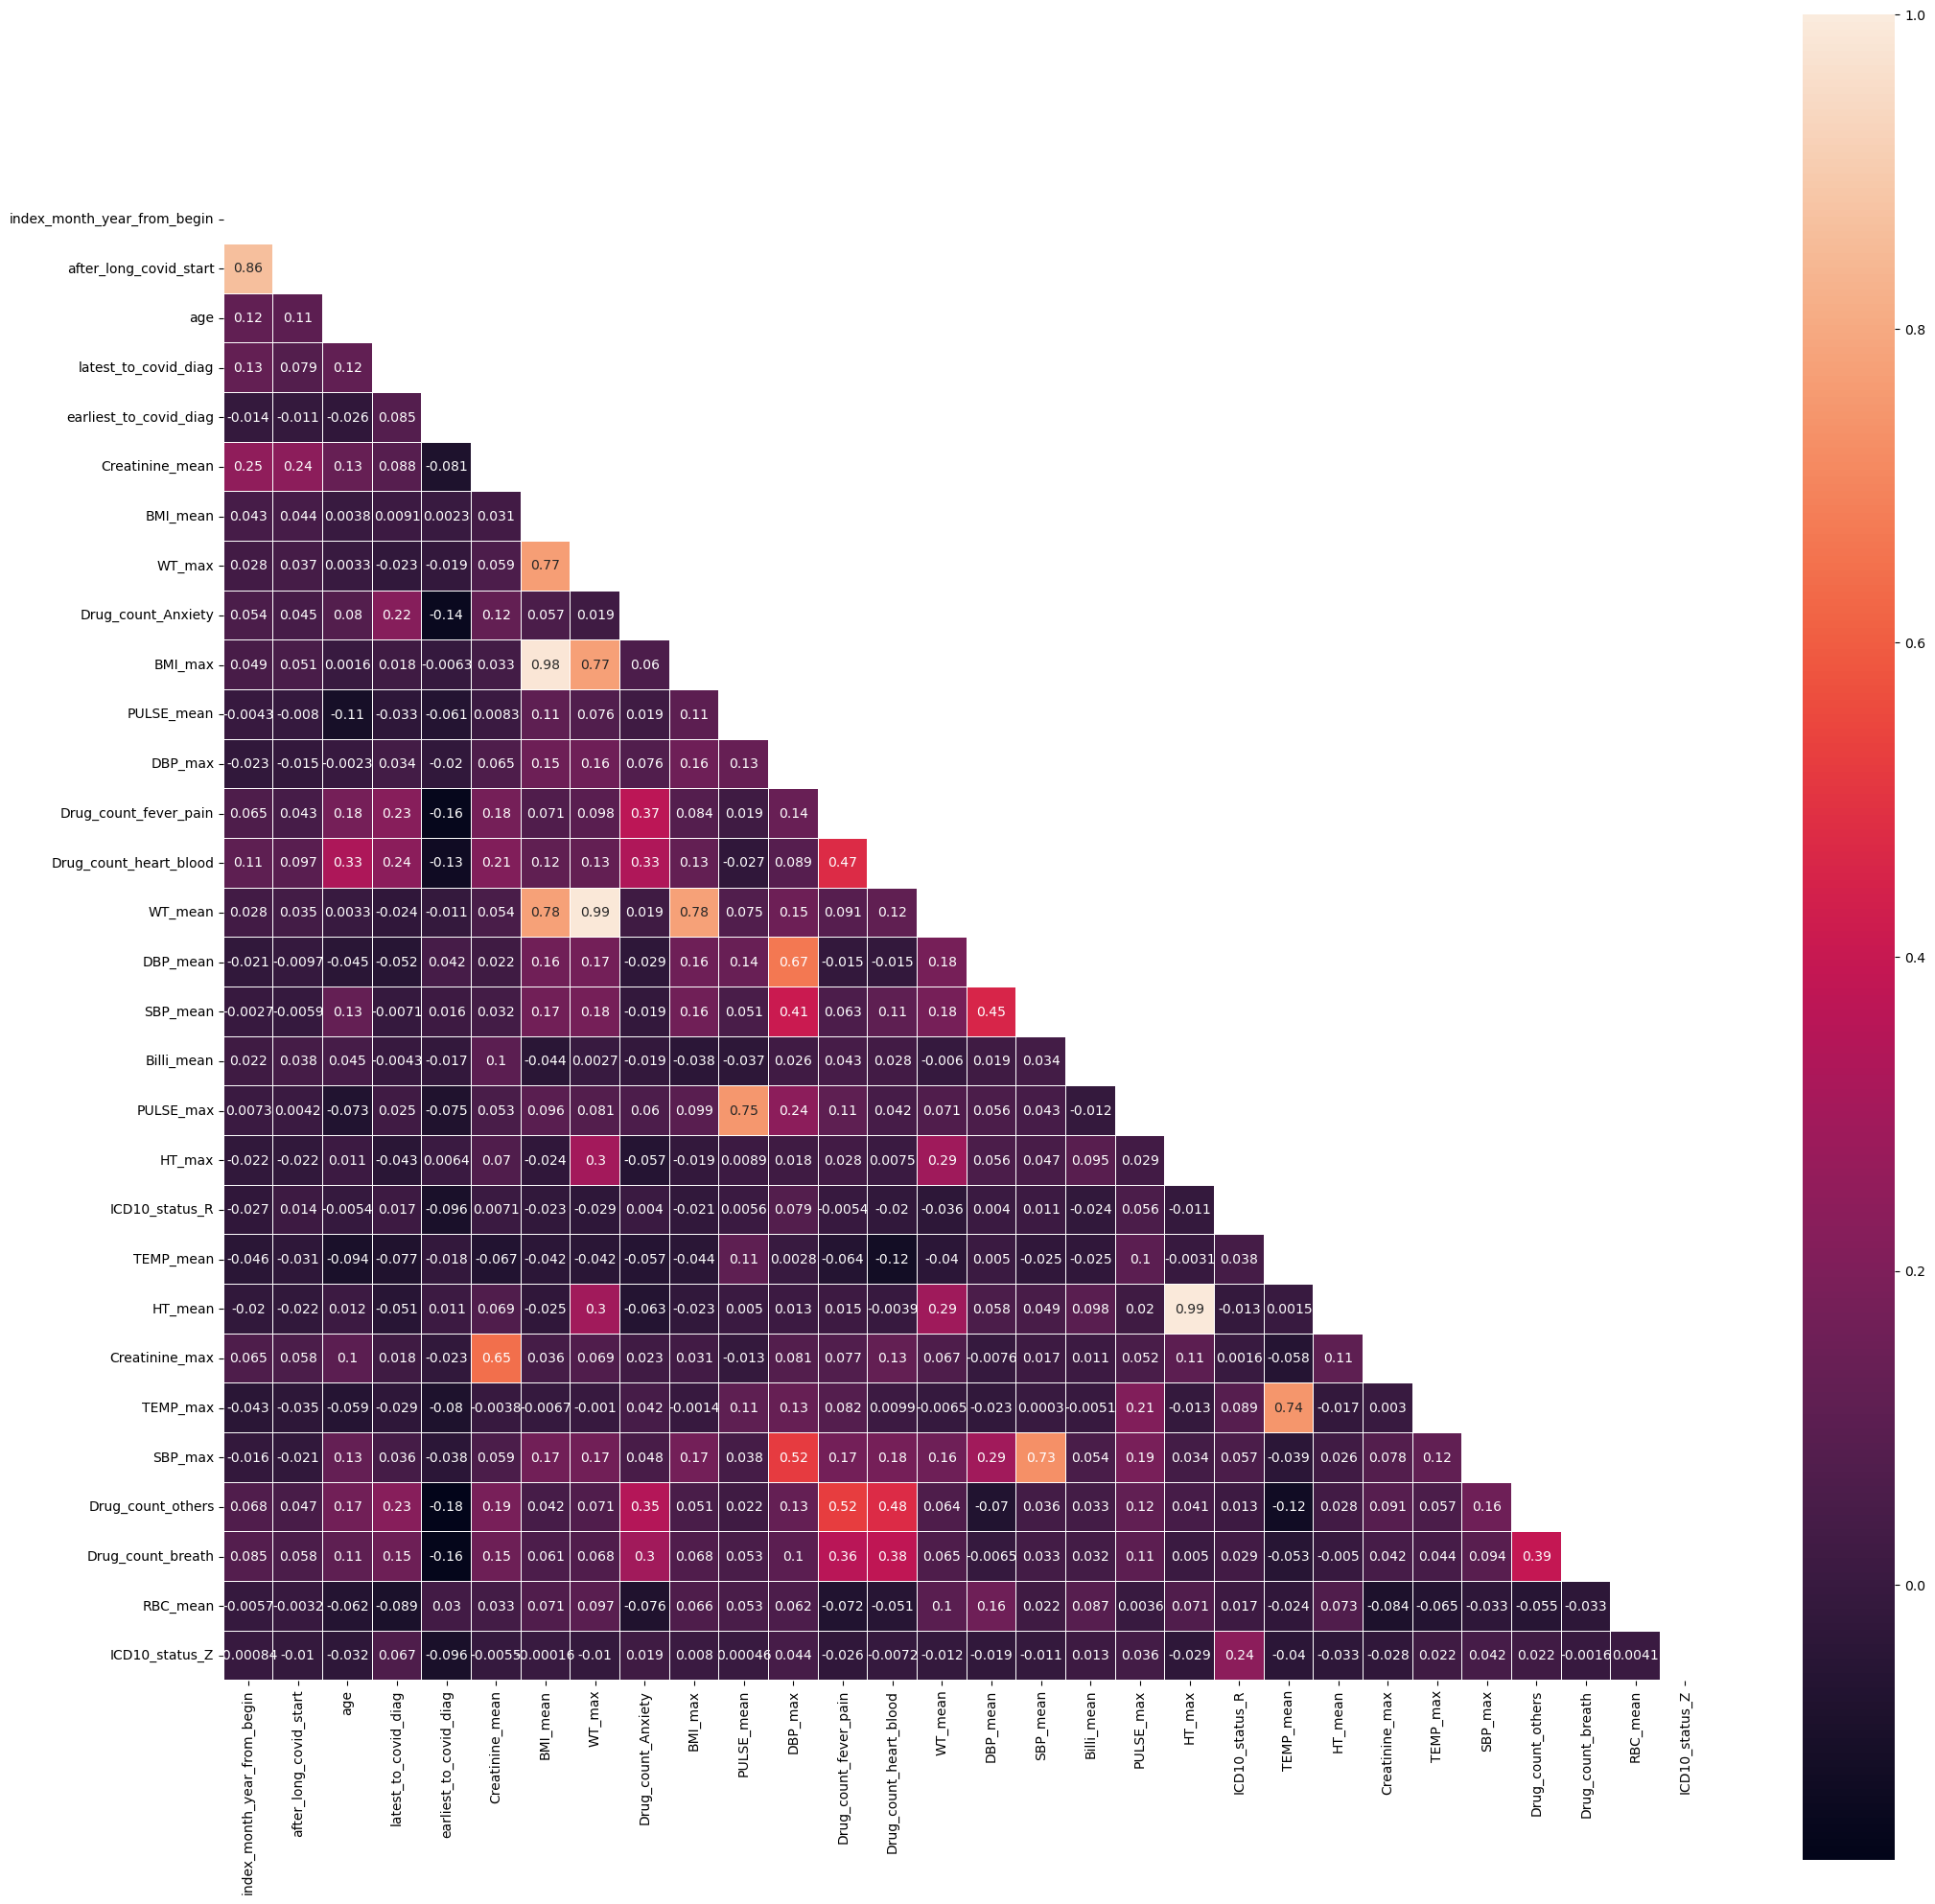

In [43]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# The correlation matrix spearman computed
# Generate a mask for the upper triangle
mask = np.zeros_like(spearman, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(25, 25))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

#sns.heatmap(spearman, mask = mask, vmax=.8, square=True)

sns.heatmap(spearman, vmin=spearman.values.min(), mask = mask, vmax=1, square=True, 
        linewidths=0.1, annot=True, annot_kws={"size":10})

In [44]:
X.shape

(3212, 161)

In [45]:
df_downsampled.shape

(3212, 162)

In [49]:
## Include more from majority for testing performance

## Train with df_downsampled
y = df_downsampled.has_long_covid_diag
X = df_downsampled.drop(['has_long_covid_diag'], axis=1)


## Do the 70%/30% training testing split, hold up the "data_test"
data_train, data_test, target_train, target_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

# resample from the majority classs
df_majority = df_processed_imputed_scaled[df_processed_imputed_scaled.has_long_covid_diag==0]
# Downsample majority class (1606 * 0.3 *200)
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=10000,     # to match minority class  #n_samples=10000,
                                 random_state=123) # reproducible results

y_major = df_majority_downsampled.has_long_covid_diag
X_major = df_majority_downsampled.drop(['has_long_covid_diag'], axis=1)


data_new_test = pd.concat([data_test, X_major])
target_new_test = pd.concat([target_test, y_major])

print(data_new_test.shape, target_new_test.shape)

(10964, 161) (10964,)


In [48]:
print(data_train.shape, target_train.shape)
## Train with "data_train", and "target_train"

model = RandomForestClassifier(n_jobs=-1, random_state=42)
model.fit(data_train, target_train)

(2248, 161) (2248,)


RandomForestClassifier(n_jobs=-1, random_state=42)

In [54]:
# Test with "data_new_test"

#y_pr = model.predict_proba(X_te)[:,1]
y_pr = model.predict(data_new_test)

auc = roc_auc_score(target_new_test, y_pr)
aps = average_precision_score(target_new_test, y_pr)

dataset = pd.DataFrame({'target_new_test': target_new_test, 'y_pr': list(y_pr)}, \
                   columns=['target_new_test', 'y_pr'])
TP = dataset[(dataset['target_new_test']==1) & (dataset['y_pr']>0)].shape[0]
FP = dataset[(dataset['target_new_test']!=1) & (dataset['y_pr']>0)].shape[0]
Positive = dataset[dataset['target_new_test']==1].shape[0]
Negative = dataset[dataset['target_new_test']!=1].shape[0]
Sensitivity = round(TP/Positive, 4)
FPR = round(FP/Negative, 4)
## FPR: FP / (FP + TN)

In [55]:
dataset

,target_new_test,y_pr
213224,0,0
62722,1,1
358594,1,0
229482,1,1
369889,1,1
...,...,...
265817,0,0
199456,0,0
59297,0,0
332372,0,0


In [56]:
print(TP, FP, Positive, Negative, Sensitivity, FPR, auc, aps)

432 1473 473 10491 0.9133 0.1404 0.8864565882807433 0.21085442514573735


In [59]:
# Test with "data_new_test", using probability

y_pr = model.predict_proba(data_new_test)[:,1]
#y_pr = model.predict(data_new_test)

auc = roc_auc_score(target_new_test, y_pr)
aps = average_precision_score(target_new_test, y_pr)

dataset = pd.DataFrame({'target_new_test': target_new_test, 'y_pr': list(y_pr)}, \
                   columns=['target_new_test', 'y_pr'])
TP = dataset[(dataset['target_new_test']==1) & (dataset['y_pr']>=0.5)].shape[0]
FP = dataset[(dataset['target_new_test']!=1) & (dataset['y_pr']>=0.5)].shape[0]
FN = dataset[(dataset['target_new_test']==1) & (dataset['y_pr']<0.5)].shape[0]
Positive = dataset[dataset['target_new_test']==1].shape[0]
Negative = dataset[dataset['target_new_test']!=1].shape[0]
Sensitivity = round(TP/Positive, 4)
FPR = round(FP/Negative, 4)
## FPR: FP / (FP + TN)


print(TP, FP, Positive, Negative, Sensitivity, FPR, auc, aps)

432 1480 473 10491 0.9133 0.1411 0.9158889437699845 0.25400514577170036
